# Суть задания


Генеративные модели (GAN, VAE)\
Общая цель:
Показать понимание архитектур, алгоритмов обучения и функций потерь в GAN, VAE, а также получить практический опыт работы с этими моделями на небольших наборах данных (например, MNIST).

Примерное время выполнения - ??? часов.

Дедлайн: 1 марта в 23:59 \
Сдача в течение 12 часов после дедлайна не штрафуется.

Штрафные коэффициенты оценивания при просрочке:

-|-
----|---
От 12 часов до 7 дней после дедлайна | 0.8
От 7 до 14 дней | 0.6
От 14 дней до конца модуля | 0.4

## Оценивание

Задание:

Критерии оценивания | Коэффициент
-------------|--------------------
Код есть, но не работает | 0
Код работает, но качество генерации хуже образцов | 0.5
Качество генерации не хуже образцов | 1

\


Часть работы | Стоимость в баллах
-------------|--------------------
VAE | 5
GAN | 4
Интерполяция | 1
Итого | 10 баллов

Формула оценивания всей работы:

О = Задание * 0.6 + ответы на вопросы * 0.3 + Тест на лекции * 0.1



Критерии оценивания | Коэффициент
-------------|--------------------
Код есть, но не работает | 0
Код работает, но качество генерации хуже образцов | 0.5
Качество генерации не хуже образцов | 1

# 0 Подготовка системы

## Импорты библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

# Задачи

# Задача 1: Реализация и обучение Variational Autoencoder (VAE) (5 баллов)

## Vanilla VAE (2 балла)

* Реализуйте VAE для набора данных MNIST. (0.5 задачи)
  * Реализуйте архитектуру с энкодером, который выводит параметры
𝜇 и 𝜎 для аппроксимированного распределения
𝑞(𝑧∣𝑥), и декодером для реконструкции
𝑥 из 𝑧.
  * Используйте функцию потерь, включающую реконструкционную ошибку (MSE или BCE) и KL-дивергенцию.
  * Обучите модель и визуализируйте результаты:
    * Сравните исходные изображения и реконструкции.
    * Сгенерируйте новые изображения, сэмплируя
* Условная генерация (0.2 задачи)
  * Дополните модель для предоставления возможности условной генерации по заданному классу
* Улучшение модели (0.2 задачи)

### Реализация энкодера

Энкодер - часть VAE, сжимающая входные данные в параметры вероятностного распределения 𝜇 и 𝜎. Для начала реализуйте базовую архитектуру:

Инициализируйте `torch.nn.Module` и определите несколько слоев для дальнейшего использования.

Пожалуйста, используйте следующую структуру сети:
- скрытый слой
 - линейный (полносвязный) слой со входом 784 и hidden_dim выходных измерений
- выходной слой для среднего значения латентного распределения
 - линейный (полносвязный) слой hidden_dim x размерность латентного пространства
- выходной слой для дисперсии латентного распределения
 - линейный (полносвязный) слой hidden_dim x размерность латентного пространства

Также реализуйте прямой проход по сети. В качестве функции активации используйте ReLU.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

### Реализация декодера

Декодер - часть VAE, получающая на вход случайных шум размера латентного пространства и восстанавливающий (генерирующий) на его основе данные. Для начала реализуйте базовую архитектуру:

Инициализируйте `torch.nn.Module` и определите несколько слоев для дальнейшего использования.

Пожалуйста, используйте следующую структуру сети:
- скрытый слой
 - линейный (полносвязный) слой со входом с размерностью латентного пространства и выходом размера hidden_dim
- выходной слой
  - линейный (полносвязный) слой со входом hidden_dim x 784 (размерность изначальных данных)



In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim=400, output_dim=784):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, hidden_dim)

        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))

        x_recon = torch.sigmoid(self.fc_out(h))
        return x_recon

### Собираем вместе



In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):

        std = torch.exp(0.5 * logvar)

        epsilon = torch.randn_like(std)

        z = mu + epsilon * std
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


### Реализация функции ошибки

In [ ]:
# Определите функцию потерь: Потери при реконструкции (BCE) + потери при расхождении KL
def loss_function(recon_x, x, mu, logvar):

    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

### Реализация обучения

#### Загрузка данных

In [ ]:
# Подготовьте датасет MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

mnist_train = dset.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

#### Обучение

In [ ]:
hidden_dim = 400 # размерность скрытого слоя
latent_dim = 20 # размерность латентного пространства


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:

num_epochs = 10
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch: 0 [0/60000 (0%)]	Loss: 549.878479
Epoch: 0 [12800/60000 (21%)]	Loss: 183.248627
Epoch: 0 [25600/60000 (43%)]	Loss: 155.396439
Epoch: 0 [38400/60000 (64%)]	Loss: 137.371429
Epoch: 0 [51200/60000 (85%)]	Loss: 128.867813
====> Epoch: 0 Average loss: 163.0815
Epoch: 1 [0/60000 (0%)]	Loss: 130.052963
Epoch: 1 [12800/60000 (21%)]	Loss: 118.229111
Epoch: 1 [25600/60000 (43%)]	Loss: 125.669205
Epoch: 1 [38400/60000 (64%)]	Loss: 118.019196
Epoch: 1 [51200/60000 (85%)]	Loss: 115.013260
====> Epoch: 1 Average loss: 120.9602
Epoch: 2 [0/60000 (0%)]	Loss: 117.890167
Epoch: 2 [12800/60000 (21%)]	Loss: 118.634796
Epoch: 2 [25600/60000 (43%)]	Loss: 121.246216
Epoch: 2 [38400/60000 (64%)]	Loss: 113.455200
Epoch: 2 [51200/60000 (85%)]	Loss: 110.738594
====> Epoch: 2 Average loss: 114.3249
Epoch: 3 [0/60000 (0%)]	Loss: 113.067108
Epoch: 3 [12800/60000 (21%)]	Loss: 111.812164
Epoch: 3 [25600/60000 (43%)]	Loss: 113.439293
Epoch: 3 [38400/60000 (64%)]	Loss: 109.581261
Epoch: 3 [51200/60000 (85%)]	Los

### Инференс (генерация)

#### Восстановление входных данных

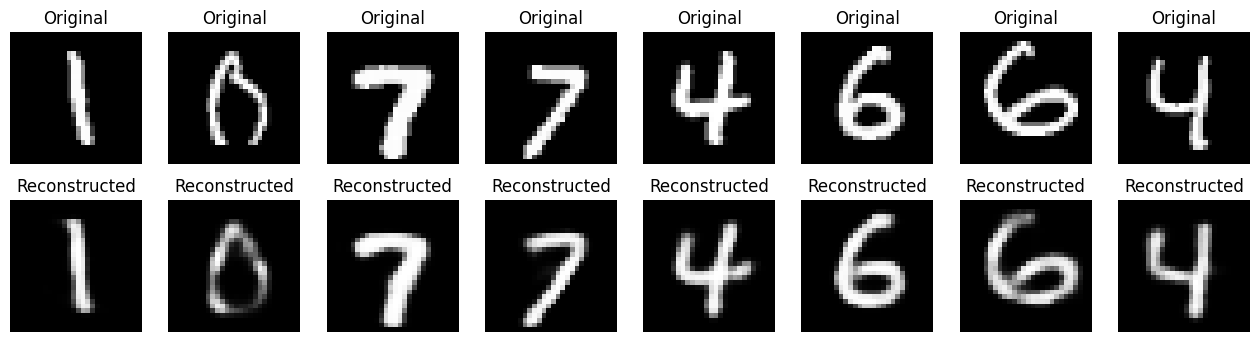

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])


mnist_test = dset.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=16, shuffle=True)

model.eval()


data_iter = iter(test_loader)
images, _ = next(data_iter)
images = images.to(device)

with torch.no_grad():
    recon_images, mu, logvar = model(images)


def plot_images(original, reconstructed, n=8):
    plt.figure(figsize=(16, 4))
    for i in range(n):

        plt.subplot(2, n, i+1)
        plt.imshow(original[i].cpu().view(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        plt.subplot(2, n, i+n+1)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

plot_images(images, recon_images, n=8)

#### Генерация новых изображений

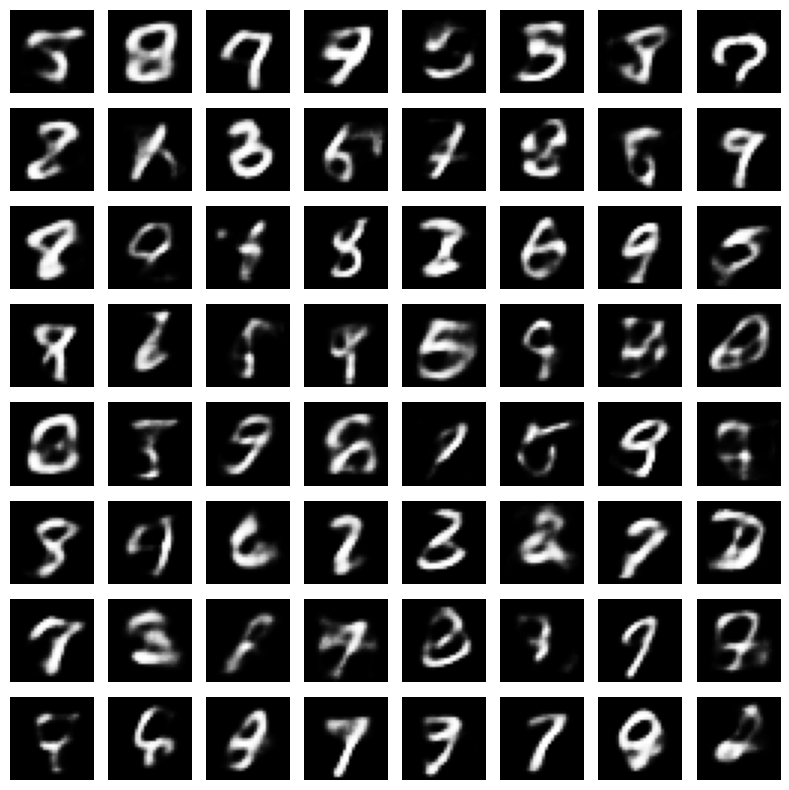

In [ ]:

with torch.no_grad():
    # Выборка латентных векторов z из стандартного нормального распределения
    # YOUR CODE HERE:
    z = torch.randn(64, latent_dim).to(device) # 64 образца случайного шума, каждый из которых имеет размерность latent_dim
    generated_images = model.decoder(z)

def plot_generated(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].view(28,28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_generated(generated_images)

## Conditional VAE (2 балла)

Как вы могли заметить, получившаяся модель а) генерирует изображения случайных классов из нашего датасета б) не очень высокого качества. Попробуем что-то с этим сделать. Для начала научим нашу модель генерировать изображения заданного класса. Такая генерация называется условной (conditional generation).

### Определение условного энкодера

Чтобы придать энкодеру возможность работы с метками классов, необходимо добавить (сконкатенировать) эти самые метки с вектором входных данных. Чтобы модель могла эти метки нормально воспринять, их нужно закодировать методом one-hot кодирования (one-hot encoding), позволяющим переводить категориальные данные в численные. При количестве классов 10 каждая метка будет превращаться в вектор такой же длины. Соответственно, вам нужно учесть это дополнение при описании входного слоя модели.

Архитектуру энкодера и декодера можете использовать аналогичную vanilla VAE.

In [ ]:
class ConditionalEncoder(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=400, latent_dim=20):
        super(ConditionalEncoder, self).__init__()

        self.fc1 = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, c):

        x_cond = torch.cat([x, c.float()], dim=1)
        h = F.relu(self.fc1(x_cond))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

### Определение условного декодера

С декодером необходимо проделать аналогичные преобразования - добавить возможность подавать на вход вместе с шумом вектор метки класса, чтобы получить ту самую условную генерацию.

In [ ]:
class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim=20, condition_dim=10, hidden_dim=400, output_dim=784):
        super(ConditionalDecoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim + condition_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, c):
        z_cond = torch.cat([z, c.float()], dim=1)
        h = F.relu(self.fc1(z_cond))
        x_recon = torch.sigmoid(self.fc_out(h))
        return x_recon

### Собираем Conditional VAE воедино

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=400, latent_dim=20):
        super(ConditionalVAE, self).__init__()
        self.encoder = ConditionalEncoder(input_dim, condition_dim, hidden_dim, latent_dim)
        self.decoder = ConditionalDecoder(latent_dim, condition_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mu + epsilon * std
        return z

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, c)
        return x_recon, mu, logvar

Функцию ошибки заново определять не нужно.

### Обучение

In [ ]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = dset.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = dset.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
hidden_dim = 400 # размерность скрытого слоя
latent_dim = 20 # размерность латентного пространства


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cond = ConditionalVAE(input_dim=784, condition_dim=10, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer_cond = optim.Adam(model_cond.parameters(), lr=1e-3)

In [ ]:

num_epochs = 10
model_cond.train()
for epoch in tqdm(range(1, num_epochs + 1)):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        conditions = F.one_hot(labels, num_classes=10).float()
        optimizer_cond.zero_grad()
        recon_batch, mu, logvar = model_cond(data, conditions)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer_cond.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 [0/60000 (0%)]	Loss: 545.694702
Epoch: 1 [12800/60000 (21%)]	Loss: 171.183914
Epoch: 1 [25600/60000 (43%)]	Loss: 152.466156
Epoch: 1 [38400/60000 (64%)]	Loss: 140.989471
Epoch: 1 [51200/60000 (85%)]	Loss: 132.764450


 10%|█         | 1/10 [00:06<01:01,  6.78s/it]

====> Epoch: 1 Average loss: 162.3164
Epoch: 2 [0/60000 (0%)]	Loss: 121.969330
Epoch: 2 [12800/60000 (21%)]	Loss: 121.854752
Epoch: 2 [25600/60000 (43%)]	Loss: 120.783592
Epoch: 2 [38400/60000 (64%)]	Loss: 118.665916
Epoch: 2 [51200/60000 (85%)]	Loss: 113.384926


 20%|██        | 2/10 [00:13<00:56,  7.03s/it]

====> Epoch: 2 Average loss: 119.6246
Epoch: 3 [0/60000 (0%)]	Loss: 112.188370
Epoch: 3 [12800/60000 (21%)]	Loss: 116.684662
Epoch: 3 [25600/60000 (43%)]	Loss: 112.449875
Epoch: 3 [38400/60000 (64%)]	Loss: 115.100334
Epoch: 3 [51200/60000 (85%)]	Loss: 110.107956


 30%|███       | 3/10 [00:21<00:49,  7.12s/it]

====> Epoch: 3 Average loss: 112.4165
Epoch: 4 [0/60000 (0%)]	Loss: 107.057961
Epoch: 4 [12800/60000 (21%)]	Loss: 107.595093
Epoch: 4 [25600/60000 (43%)]	Loss: 111.160133
Epoch: 4 [38400/60000 (64%)]	Loss: 114.561752
Epoch: 4 [51200/60000 (85%)]	Loss: 111.855614


 40%|████      | 4/10 [00:27<00:41,  6.92s/it]

====> Epoch: 4 Average loss: 109.2072
Epoch: 5 [0/60000 (0%)]	Loss: 109.551651
Epoch: 5 [12800/60000 (21%)]	Loss: 109.539307
Epoch: 5 [25600/60000 (43%)]	Loss: 104.759659
Epoch: 5 [38400/60000 (64%)]	Loss: 111.253883
Epoch: 5 [51200/60000 (85%)]	Loss: 106.712921


 50%|█████     | 5/10 [00:35<00:35,  7.03s/it]

====> Epoch: 5 Average loss: 107.1740
Epoch: 6 [0/60000 (0%)]	Loss: 105.801910
Epoch: 6 [12800/60000 (21%)]	Loss: 106.566284
Epoch: 6 [25600/60000 (43%)]	Loss: 104.946877
Epoch: 6 [38400/60000 (64%)]	Loss: 106.987076
Epoch: 6 [51200/60000 (85%)]	Loss: 103.028976


 60%|██████    | 6/10 [00:41<00:27,  6.89s/it]

====> Epoch: 6 Average loss: 105.7293
Epoch: 7 [0/60000 (0%)]	Loss: 108.111214
Epoch: 7 [12800/60000 (21%)]	Loss: 104.642303
Epoch: 7 [25600/60000 (43%)]	Loss: 112.046806
Epoch: 7 [38400/60000 (64%)]	Loss: 104.497673
Epoch: 7 [51200/60000 (85%)]	Loss: 103.777557


 70%|███████   | 7/10 [00:48<00:21,  7.02s/it]

====> Epoch: 7 Average loss: 104.7281
Epoch: 8 [0/60000 (0%)]	Loss: 103.501389
Epoch: 8 [12800/60000 (21%)]	Loss: 105.058281
Epoch: 8 [25600/60000 (43%)]	Loss: 102.408455
Epoch: 8 [38400/60000 (64%)]	Loss: 105.166458
Epoch: 8 [51200/60000 (85%)]	Loss: 104.055199


 80%|████████  | 8/10 [00:55<00:13,  6.97s/it]

====> Epoch: 8 Average loss: 103.9003
Epoch: 9 [0/60000 (0%)]	Loss: 100.372025
Epoch: 9 [12800/60000 (21%)]	Loss: 103.790207
Epoch: 9 [25600/60000 (43%)]	Loss: 102.497406
Epoch: 9 [38400/60000 (64%)]	Loss: 105.487427
Epoch: 9 [51200/60000 (85%)]	Loss: 106.067825


 90%|█████████ | 9/10 [01:03<00:07,  7.06s/it]

====> Epoch: 9 Average loss: 103.2340
Epoch: 10 [0/60000 (0%)]	Loss: 98.756981
Epoch: 10 [12800/60000 (21%)]	Loss: 102.396751
Epoch: 10 [25600/60000 (43%)]	Loss: 102.225815
Epoch: 10 [38400/60000 (64%)]	Loss: 101.654442
Epoch: 10 [51200/60000 (85%)]	Loss: 101.504250


100%|██████████| 10/10 [01:10<00:00,  7.07s/it]

====> Epoch: 10 Average loss: 102.6720


### Восстановление изображений

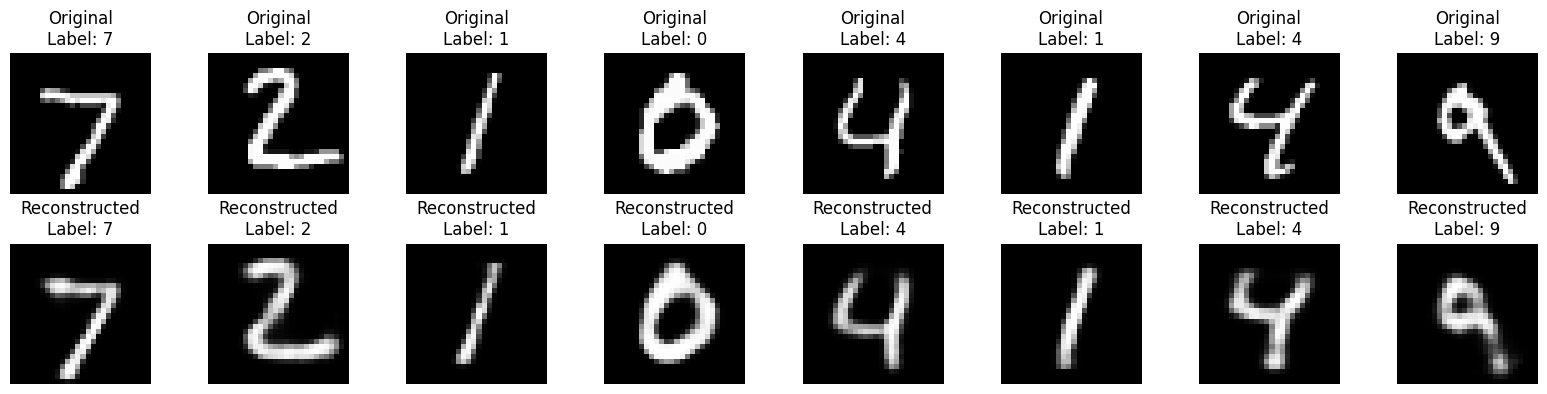

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

# YOUR CODE HERE:
conditions = F.one_hot(labels, num_classes=10).float() # Преобразуйте метки в one-hot кодировку для данного условия.

with torch.no_grad():
    recon_images, mu, logvar = model_cond(images, conditions)

def plot_images(original, reconstructed, conditions, n=8):
    labels = conditions.argmax(dim=1)
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Original\nLabel: {labels[i].item()}")
        plt.axis("off")
        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Reconstructed\nLabel: {labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_images(images, recon_images, conditions, n=8)

### Сэмплирование новых изображений

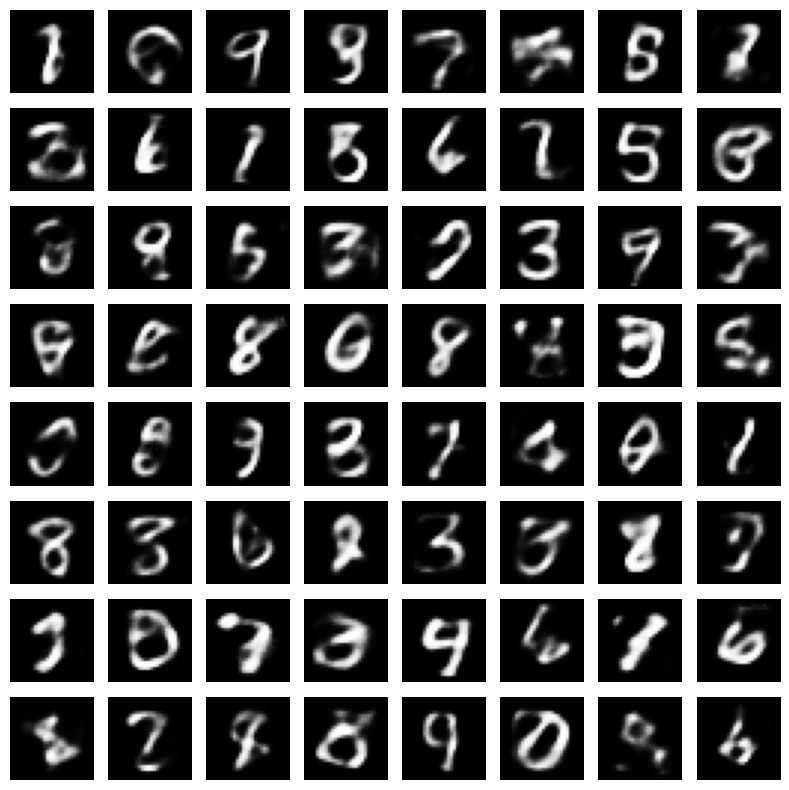

In [ ]:
latent_dim = 20


with torch.no_grad():
    # Выборка латентных векторов z из стандартного нормального распределения
    # YOUR CODE HERE:
    z = torch.randn(64, 20).to(device) # 64 образца случайного шума, каждый из которых имеет размерность latent_dim

    random_labels = torch.randint(0, 10, (64,)).to(device)
    conditions = F.one_hot(random_labels, num_classes=10).float()

    generated_images = model_cond.decoder(z, conditions)

def plot_generated(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].view(28,28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_generated(generated_images)

## Улучшение модели (1 балл)


Стало лучше (и визуально, и по значениям loss). Но вы всё ещё можете улучшить приёмами, с которыми вы уже знакомы! Попробуйте поменять различные параметры модели и обучения, чтобы получить более качественные результаты

Например, можете поменять:
- Архитектуру энкодера и декодера (добавить/изменить слои)
- Количество эпох обучения
- Размерность латентного пространства
- Параметры оптимизатора
- ...

Epoch: 0 Batch: 0 Loss: 494.906525 (β=0.00)
Epoch: 0 Batch: 100 Loss: 153.710815 (β=0.00)
Epoch: 0 Batch: 200 Loss: 103.606918 (β=0.00)
Epoch: 0 Batch: 300 Loss: 81.990021 (β=0.00)
Epoch: 0 Batch: 400 Loss: 77.742920 (β=0.00)
Epoch: 0 Average loss: 121.9552 (β=0.00)
Epoch: 1 Batch: 0 Loss: 133.831055 (β=0.10)
Epoch: 1 Batch: 100 Loss: 82.958778 (β=0.10)
Epoch: 1 Batch: 200 Loss: 83.991119 (β=0.10)
Epoch: 1 Batch: 300 Loss: 82.975777 (β=0.10)
Epoch: 1 Batch: 400 Loss: 82.422760 (β=0.10)
Epoch: 1 Average loss: 84.9011 (β=0.10)
Epoch: 2 Batch: 0 Loss: 90.158546 (β=0.20)
Epoch: 2 Batch: 100 Loss: 84.598618 (β=0.20)
Epoch: 2 Batch: 200 Loss: 83.096275 (β=0.20)
Epoch: 2 Batch: 300 Loss: 84.793900 (β=0.20)
Epoch: 2 Batch: 400 Loss: 82.070053 (β=0.20)
Epoch: 2 Average loss: 83.4030 (β=0.20)
Epoch: 3 Batch: 0 Loss: 86.810646 (β=0.30)
Epoch: 3 Batch: 100 Loss: 83.878365 (β=0.30)
Epoch: 3 Batch: 200 Loss: 87.815544 (β=0.30)
Epoch: 3 Batch: 300 Loss: 84.776108 (β=0.30)
Epoch: 3 Batch: 400 Loss: 84

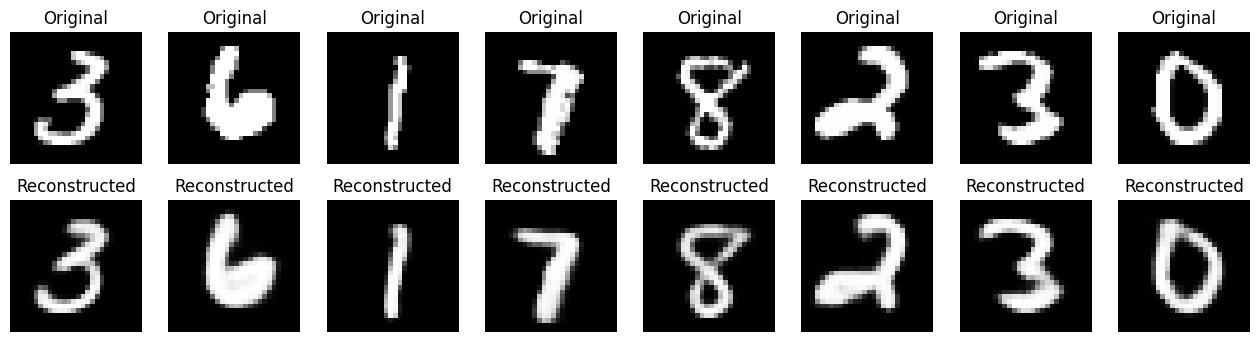

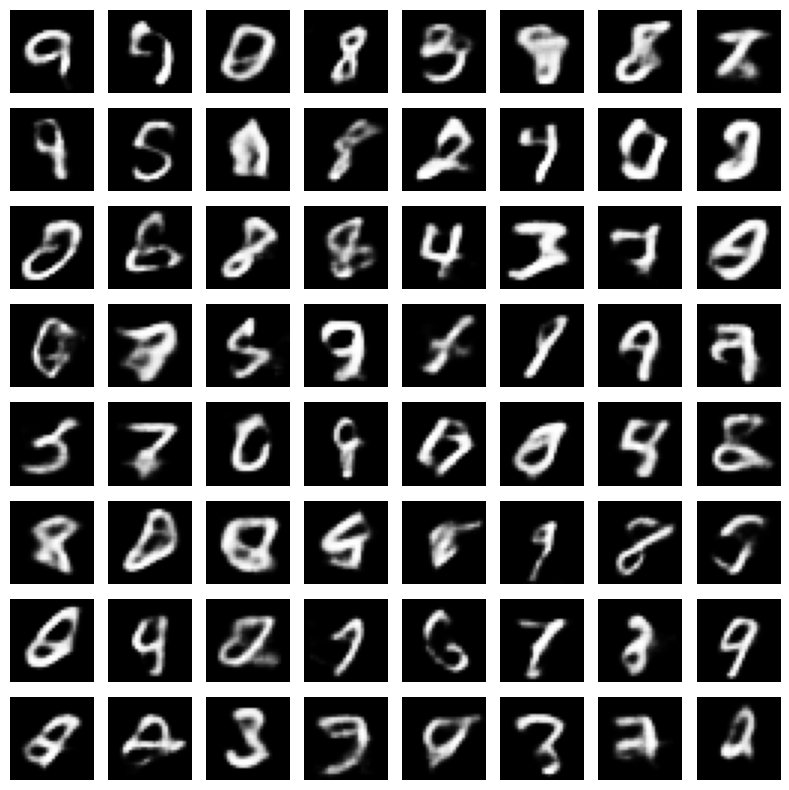

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 64 * 7 * 7)
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        h = F.relu(self.enc_conv1(x))
        h = F.relu(self.enc_conv2(h))
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_conv1(h))
        h = torch.sigmoid(self.dec_conv2(h))
        return h

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KL


transform_conv = transforms.Compose([transforms.ToTensor()])
mnist_train_conv = dset.MNIST(root='./data', train=True, transform=transform_conv, download=True)
train_loader_conv = DataLoader(mnist_train_conv, batch_size=128, shuffle=True)
mnist_test_conv = dset.MNIST(root='./data', train=False, transform=transform_conv, download=True)
test_loader_conv = DataLoader(mnist_test_conv, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = ConvVAE(latent_dim=20).to(device)
optimizer_conv = optim.Adam(model_conv.parameters(), lr=1e-3)


num_epochs = 20
anneal_epochs = 10

model_conv.train()
for epoch in range(num_epochs):

    beta = min(1.0, epoch / anneal_epochs)
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader_conv):
        data = data.to(device)
        optimizer_conv.zero_grad()
        recon_batch, mu, logvar = model_conv(data)
        loss = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer_conv.step()
        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} Batch: {batch_idx} Loss: {loss.item() / len(data):.6f} (β={beta:.2f})')
    print(f'Epoch: {epoch} Average loss: {train_loss / len(mnist_train_conv):.4f} (β={beta:.2f})')


model_conv.eval()
with torch.no_grad():
    data_iter = iter(test_loader_conv)
    images, _ = next(data_iter)
    images = images.to(device)
    recon_images, _, _ = model_conv(images)

def plot_conv_images(original, reconstructed, n=8):
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(original[i].view(28,28).cpu().numpy(), cmap='gray')
        plt.title("Original")
        plt.axis("off")
        plt.subplot(2, n, i+n+1)
        plt.imshow(reconstructed[i].view(28,28).cpu().numpy(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

plot_conv_images(images, recon_images, n=8)

# --- Генерация новых изображений ---
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    generated_images = model_conv.decode(z)

def plot_generated_conv(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].view(28, 28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_generated_conv(generated_images)

# Задача 2: Реализация и обучение Generative Adversarial Network GAN (4 балла)

GAN — это класс моделей глубокого обучения, состоящий из двух сетей: генератора и дискриминатора, которые обучаются одновременно: генератор создает данные, а дискриминатор оценивает их достоверность

* **Реализация Vanilla GAN (0.5 задачи)**  
   - Создайте архитектуру GAN, состоящую из:  
     - Генератора, который принимает на вход случайный шум (вектор) и генерирует изображение.  
     - Дискриминатора, который классифицирует изображение как реальное или сгенерированное.  
   - Используйте функцию потерь, основанную на бинарной кросс-энтропии (Binary Cross-Entropy Loss).  
   - Обучите модель, чередуя обновление весов генератора и дискриминатора.  
   - Визуализируйте результаты:  
     - Покажите примеры изображений, сгенерированных обученным генератором.

* **Условная генерация (0.5 задачи)**  
   - Дополните GAN для реализации условной генерации (Conditional GAN, cGAN), где генератор и дискриминатор также принимают на вход метки классов.  
   - Проверьте, как модель справляется с генерацией изображений заданного класса.

## Vanilla GAN (2 балла)

### Реализация генератора

Генератор — это часть GAN, которая создает новые данные, принимая на вход случайный шум и преобразуя его в данные, похожие на реальные. Для начала реализуйте базовую архитектуру:
- линейный слой с параметрами:
  * размер входа - `noise_dim`
  * размер выхода - 256
- функция активации `ReLU()`
- линейный слой с параметрами:
  * размер входа - 256
  * размер выхода - 512
- функция активации `ReLU()`
- линейный слой с параметрами:
  * размер входа - 512
  * размер выхода - 1024
- функция активации `ReLU()`
- линейный слой с параметрами:
  * размер входа - 1024
  * размер выхода - произведение выходных размерностей (размеров изображения) `output_shape`
- функция активации `Tanh()`

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, output_shape=(1, 28, 28)):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.output_shape = output_shape
        self.img_size = output_shape[0] * output_shape[1] * output_shape[2]

        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, self.img_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.fc(z)
        img = img.view(z.size(0), *self.output_shape)
        return img

### Реализация дискриминатора

Дискриминатор — это часть GAN, задача которой состоит в классификации входных данных как реальных (из тренировочного набора данных), так и  сгенерированных (созданных генератором).

Он нужен для того, чтобы отличить сгенерированное изображение от настоящего, что затем используется при обучении генератора.

Используйте следующую архитектуру:
* Выровняйте/расплюшьте/разгладьте входное изображение
* Линейный слой с параметрами:
  - размер входа равен произведению размероностей изображения `input_dim`
  - размер выхода равен 1024
* Функция активации LeakyReLU(0.2, inplace=True)
* Линейный слой с параметрами:
  - размер входа равен 1024
  - размер выхода равен 512
* Функция активации LeakyReLU(0.2, inplace=True)
* Линейный слой с параметрами:
  - размер входа равен 512
  - размер выхода равен 256
* Функция активации LeakyReLU(0.2, inplace=True)
* Линейный слой с параметрами:
  - размер входа равен 256
  - размер выхода равен 1
* Функция активации Sigmoid()

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super(Discriminator, self).__init__()
        self.input_shape = input_shape
        self.img_dim = input_shape[0] * input_shape[1] * input_shape[2]

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.img_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        result = self.fc(img)
        return result


### Подготовка к обучению

Определите функцию ошибки, создайте моедил генератора и дискриминатора, создайте оптимизаторы для генератора и дискриминатора

In [ ]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = dset.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = dset.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.BCELoss() # TODO: Исопльзуйте BCE функцию ошибки

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Обучение

In [ ]:
from tqdm import tqdm

noise_dim = 100
epochs = 50
for epoch in tqdm(range(epochs)):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)

        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        optimizer_d.zero_grad()
        outputs_real = discriminator(real_images)
        d_loss_real = criterion(outputs_real, real_labels)
        d_loss_real.backward()

        noise = torch.randn(batch_size_curr, noise_dim).to(device)
        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.step()

        optimizer_g.zero_grad()
        noise = torch.randn(batch_size_curr, noise_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    # TODO: Выведите результаты текущей эпохи: сумму D Loss и значение G Loss
    print(f"Epoch [{epoch+1}/{epochs}] D Loss: {d_loss_epoch/len(train_loader):.4f}, G Loss: {g_loss_epoch/len(train_loader):.4f}, sum: {g_loss_epoch+d_loss_epoch/len(train_loader):.4f}")


  2%|▏         | 1/50 [00:09<07:50,  9.61s/it]

Epoch [1/50] D Loss: 0.7768, G Loss: 4.0653


  4%|▍         | 2/50 [00:19<07:38,  9.55s/it]

Epoch [2/50] D Loss: 0.6807, G Loss: 4.0498


  6%|▌         | 3/50 [00:28<07:27,  9.52s/it]

Epoch [3/50] D Loss: 0.4535, G Loss: 3.9621


  8%|▊         | 4/50 [00:37<07:12,  9.40s/it]

Epoch [4/50] D Loss: 0.3619, G Loss: 4.6327


 10%|█         | 5/50 [00:47<07:00,  9.34s/it]

Epoch [5/50] D Loss: 0.3646, G Loss: 4.6311


 12%|█▏        | 6/50 [00:56<06:53,  9.39s/it]

Epoch [6/50] D Loss: 0.2489, G Loss: 4.8269


 14%|█▍        | 7/50 [01:05<06:44,  9.40s/it]

Epoch [7/50] D Loss: 0.2632, G Loss: 4.9107


 16%|█▌        | 8/50 [01:15<06:35,  9.42s/it]

Epoch [8/50] D Loss: 0.2654, G Loss: 4.7794


 18%|█▊        | 9/50 [01:24<06:20,  9.29s/it]

Epoch [9/50] D Loss: 0.3006, G Loss: 4.7188


 20%|██        | 10/50 [01:33<06:14,  9.37s/it]

Epoch [10/50] D Loss: 0.3086, G Loss: 4.9331


 22%|██▏       | 11/50 [01:43<06:06,  9.41s/it]

Epoch [11/50] D Loss: 0.3882, G Loss: 4.8403


 24%|██▍       | 12/50 [01:52<05:58,  9.44s/it]

Epoch [12/50] D Loss: 0.4202, G Loss: 4.7889


 26%|██▌       | 13/50 [02:02<05:47,  9.38s/it]

Epoch [13/50] D Loss: 0.4475, G Loss: 4.5933


 28%|██▊       | 14/50 [02:11<05:36,  9.34s/it]

Epoch [14/50] D Loss: 0.4802, G Loss: 4.1761


 30%|███       | 15/50 [02:20<05:28,  9.39s/it]

Epoch [15/50] D Loss: 0.4771, G Loss: 3.9659


 32%|███▏      | 16/50 [02:30<05:19,  9.39s/it]

Epoch [16/50] D Loss: 0.5037, G Loss: 3.6510


 34%|███▍      | 17/50 [02:39<05:10,  9.41s/it]

Epoch [17/50] D Loss: 0.4897, G Loss: 3.4491


 36%|███▌      | 18/50 [02:48<04:56,  9.27s/it]

Epoch [18/50] D Loss: 0.4675, G Loss: 3.5195


 38%|███▊      | 19/50 [02:58<04:48,  9.32s/it]

Epoch [19/50] D Loss: 0.4716, G Loss: 3.3956


 40%|████      | 20/50 [03:07<04:40,  9.36s/it]

Epoch [20/50] D Loss: 0.4588, G Loss: 3.2881


 42%|████▏     | 21/50 [03:17<04:31,  9.37s/it]

Epoch [21/50] D Loss: 0.4610, G Loss: 3.1978


 44%|████▍     | 22/50 [03:26<04:21,  9.34s/it]

Epoch [22/50] D Loss: 0.4561, G Loss: 3.1045


 46%|████▌     | 23/50 [03:35<04:10,  9.29s/it]

Epoch [23/50] D Loss: 0.4461, G Loss: 3.0603


 48%|████▊     | 24/50 [03:45<04:04,  9.41s/it]

Epoch [24/50] D Loss: 0.4388, G Loss: 2.9999


 50%|█████     | 25/50 [03:54<03:57,  9.50s/it]

Epoch [25/50] D Loss: 0.4197, G Loss: 2.9203


 52%|█████▏    | 26/50 [04:04<03:49,  9.54s/it]

Epoch [26/50] D Loss: 0.4101, G Loss: 2.9126


 54%|█████▍    | 27/50 [04:14<03:39,  9.54s/it]

Epoch [27/50] D Loss: 0.3898, G Loss: 2.8672


 56%|█████▌    | 28/50 [04:23<03:30,  9.58s/it]

Epoch [28/50] D Loss: 0.3718, G Loss: 2.8695


 58%|█████▊    | 29/50 [04:33<03:22,  9.66s/it]

Epoch [29/50] D Loss: 0.3657, G Loss: 2.8743


 60%|██████    | 30/50 [04:43<03:14,  9.74s/it]

Epoch [30/50] D Loss: 0.3611, G Loss: 2.8431


 62%|██████▏   | 31/50 [04:53<03:05,  9.78s/it]

Epoch [31/50] D Loss: 0.3586, G Loss: 2.8522


 64%|██████▍   | 32/50 [05:03<02:56,  9.82s/it]

Epoch [32/50] D Loss: 0.3557, G Loss: 2.8382


 66%|██████▌   | 33/50 [05:12<02:43,  9.64s/it]

Epoch [33/50] D Loss: 0.3519, G Loss: 2.8636


 68%|██████▊   | 34/50 [05:22<02:33,  9.62s/it]

Epoch [34/50] D Loss: 0.3476, G Loss: 2.8396


 70%|███████   | 35/50 [05:31<02:23,  9.60s/it]

Epoch [35/50] D Loss: 0.3490, G Loss: 2.8364


 72%|███████▏  | 36/50 [05:41<02:13,  9.55s/it]

Epoch [36/50] D Loss: 0.3452, G Loss: 2.8364


 74%|███████▍  | 37/50 [05:50<02:02,  9.43s/it]

Epoch [37/50] D Loss: 0.3406, G Loss: 2.8054


 76%|███████▌  | 38/50 [05:59<01:52,  9.38s/it]

Epoch [38/50] D Loss: 0.3441, G Loss: 2.8155


 78%|███████▊  | 39/50 [06:08<01:43,  9.42s/it]

Epoch [39/50] D Loss: 0.3471, G Loss: 2.7846


 80%|████████  | 40/50 [06:18<01:34,  9.44s/it]

Epoch [40/50] D Loss: 0.3515, G Loss: 2.7599


 82%|████████▏ | 41/50 [06:27<01:25,  9.45s/it]

Epoch [41/50] D Loss: 0.3562, G Loss: 2.7335


 84%|████████▍ | 42/50 [06:36<01:14,  9.29s/it]

Epoch [42/50] D Loss: 0.3550, G Loss: 2.7254


 86%|████████▌ | 43/50 [06:46<01:05,  9.43s/it]

Epoch [43/50] D Loss: 0.3657, G Loss: 2.6919


 88%|████████▊ | 44/50 [06:56<00:57,  9.53s/it]

Epoch [44/50] D Loss: 0.3648, G Loss: 2.6688


 90%|█████████ | 45/50 [07:06<00:47,  9.59s/it]

Epoch [45/50] D Loss: 0.3631, G Loss: 2.6703


 92%|█████████▏| 46/50 [07:16<00:38,  9.70s/it]

Epoch [46/50] D Loss: 0.3606, G Loss: 2.6438


 94%|█████████▍| 47/50 [07:25<00:28,  9.51s/it]

Epoch [47/50] D Loss: 0.3663, G Loss: 2.6336


 96%|█████████▌| 48/50 [07:34<00:19,  9.52s/it]

Epoch [48/50] D Loss: 0.3642, G Loss: 2.6236


 98%|█████████▊| 49/50 [07:44<00:09,  9.52s/it]

Epoch [49/50] D Loss: 0.3642, G Loss: 2.6088


100%|██████████| 50/50 [07:53<00:00,  9.47s/it]

Epoch [50/50] D Loss: 0.3648, G Loss: 2.6084


### Сэмплирование изображений

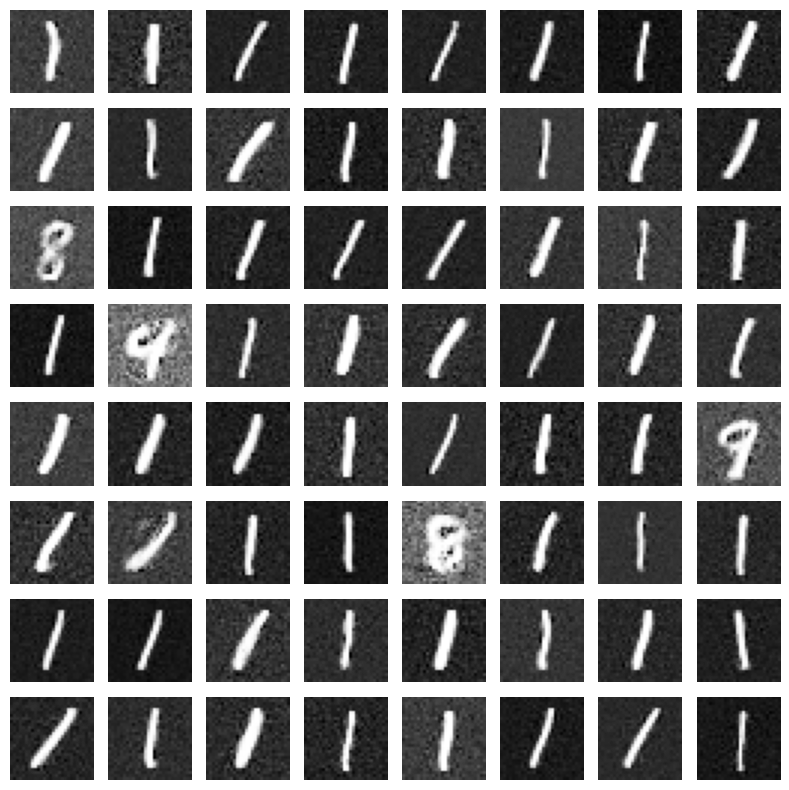

In [ ]:
import matplotlib.pyplot as plt

# YOUR CODE HERE:
noise = torch.randn(64, noise_dim).to(device) # 64 образца случайного шума, каждый из которых имеет размерность noise_dim
generated_images = generator(noise).cpu().detach()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = generated_images[i].view(28,28).numpy()
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Conditional GAN (2 балла)

Аналогично с Conditional VAE попробуем улучшить качество генерации и получить возможность управлять ей при помощи создания Conditional GAN.

### Условный генератор

Чтобы придать генератору возможность работы с метками классов, необходимо добавить (сконкатенировать) эти самые метки с вектором шума. Как и раньше метки кодируются при помощи one-hot encoding. Соответственно, вам нужно учесть это дополнение при описании входного слоя модели.

Архитектуры генератора и дискриминатора можете использовать аналогичные Vanilla GAN.

In [ ]:
import torch.nn.functional as F  # для one_hot

class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=10, output_shape=(1, 28, 28)):
        super(ConditionalGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.num_classes = num_classes
        self.output_shape = output_shape
        self.img_size = output_shape[0] * output_shape[1] * output_shape[2]

        self.fc = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, self.img_size),
            nn.Tanh()
        )

    def forward(self, z, c):
        # z: шум, c: one-hot вектор класса
        input_vec = torch.cat([z, c], dim=1)
        x = self.fc(input_vec)
        x = x.view(z.size(0), *self.output_shape)
        return x

### Условный дискриминатор

С дискриминатором необходимо проделать аналогичные преобразования - добавить возможность подавать на вход вместе с изображением вектор метки класса.

In [ ]:
import torch
import torch.nn as nn

class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), num_classes=10):
        super(ConditionalDiscriminator, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.img_dim = input_shape[0] * input_shape[1] * input_shape[2]

        input_dim = self.img_dim + num_classes

        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, c):

        img_flat = img.view(img.size(0), -1)

        input_vec = torch.cat([img_flat, c], dim=1)
        output = self.fc(input_vec)
        return output

### Подготовка к обучению

In [ ]:
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
lr = 0.0004
noise_dim = 100
num_classes = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
import torchvision
import torch.optim as optim

train_dataset_cond = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader_cond = torch.utils.data.DataLoader(train_dataset_cond, batch_size=batch_size, shuffle=True)

conditional_generator = ConditionalGenerator(noise_dim=noise_dim, num_classes=num_classes, output_shape=(1, 28, 28)).to(device)
conditional_discriminator = ConditionalDiscriminator(input_shape=(1, 28, 28), num_classes=num_classes).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(conditional_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(conditional_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

### Обучение

In [ ]:
from tqdm import tqdm

epochs = 50
for epoch in tqdm(range(epochs), desc="Conditional GAN training"):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0
    for i, (real_images, labels) in enumerate(train_loader_cond):
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)


        labels_onehot = F.one_hot(labels, num_classes=num_classes).float().to(device)

        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)


        optimizer_D.zero_grad()
        outputs_real = conditional_discriminator(real_images, labels_onehot)
        d_loss_real = criterion(outputs_real, real_labels)
        d_loss_real.backward()

        noise = torch.randn(batch_size_curr, noise_dim).to(device)
        fake_images = conditional_generator(noise, labels_onehot)
        outputs_fake = conditional_discriminator(fake_images.detach(), labels_onehot)
        d_loss_fake = criterion(outputs_fake, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_D.step()


        optimizer_G.zero_grad()
        noise = torch.randn(batch_size_curr, noise_dim).to(device)
        fake_images = conditional_generator(noise, labels_onehot)
        outputs = conditional_discriminator(fake_images, labels_onehot)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] D Loss: {d_loss_epoch/len(train_loader_cond):.4f}, G Loss: {g_loss_epoch/len(train_loader_cond):.4f}")

Conditional GAN training:   2%|▏         | 1/50 [00:14<12:07, 14.86s/it]

Epoch [1/50] D Loss: 1.0555, G Loss: 1.3975


Conditional GAN training:   4%|▍         | 2/50 [00:29<11:47, 14.74s/it]

Epoch [2/50] D Loss: 0.9698, G Loss: 1.8702


Conditional GAN training:   6%|▌         | 3/50 [00:44<11:42, 14.95s/it]

Epoch [3/50] D Loss: 0.8380, G Loss: 2.2009


Conditional GAN training:   8%|▊         | 4/50 [00:59<11:26, 14.93s/it]

Epoch [4/50] D Loss: 0.7984, G Loss: 2.2410


Conditional GAN training:  10%|█         | 5/50 [01:14<11:08, 14.86s/it]

Epoch [5/50] D Loss: 0.7250, G Loss: 2.3993


Conditional GAN training:  12%|█▏        | 6/50 [01:28<10:50, 14.78s/it]

Epoch [6/50] D Loss: 0.7090, G Loss: 2.4240


Conditional GAN training:  14%|█▍        | 7/50 [01:43<10:33, 14.74s/it]

Epoch [7/50] D Loss: 0.7707, G Loss: 2.1908


Conditional GAN training:  16%|█▌        | 8/50 [01:58<10:23, 14.86s/it]

Epoch [8/50] D Loss: 0.9080, G Loss: 1.7674


Conditional GAN training:  18%|█▊        | 9/50 [02:14<10:24, 15.22s/it]

Epoch [9/50] D Loss: 0.9927, G Loss: 1.5217


Conditional GAN training:  20%|██        | 10/50 [02:29<10:00, 15.02s/it]

Epoch [10/50] D Loss: 1.0551, G Loss: 1.3715


Conditional GAN training:  22%|██▏       | 11/50 [02:43<09:40, 14.88s/it]

Epoch [11/50] D Loss: 1.0735, G Loss: 1.3215


Conditional GAN training:  24%|██▍       | 12/50 [02:59<09:28, 14.96s/it]

Epoch [12/50] D Loss: 1.0946, G Loss: 1.2744


Conditional GAN training:  26%|██▌       | 13/50 [03:13<09:10, 14.87s/it]

Epoch [13/50] D Loss: 1.1200, G Loss: 1.2414


Conditional GAN training:  28%|██▊       | 14/50 [03:28<08:55, 14.88s/it]

Epoch [14/50] D Loss: 1.1529, G Loss: 1.1623


Conditional GAN training:  30%|███       | 15/50 [03:43<08:44, 14.98s/it]

Epoch [15/50] D Loss: 1.1644, G Loss: 1.1368


Conditional GAN training:  32%|███▏      | 16/50 [03:59<08:38, 15.24s/it]

Epoch [16/50] D Loss: 1.1727, G Loss: 1.1147


Conditional GAN training:  34%|███▍      | 17/50 [04:14<08:23, 15.24s/it]

Epoch [17/50] D Loss: 1.1857, G Loss: 1.0911


Conditional GAN training:  36%|███▌      | 18/50 [04:30<08:11, 15.37s/it]

Epoch [18/50] D Loss: 1.1939, G Loss: 1.0673


Conditional GAN training:  38%|███▊      | 19/50 [04:46<08:04, 15.63s/it]

Epoch [19/50] D Loss: 1.1926, G Loss: 1.0556


Conditional GAN training:  40%|████      | 20/50 [05:02<07:49, 15.65s/it]

Epoch [20/50] D Loss: 1.1992, G Loss: 1.0578


Conditional GAN training:  42%|████▏     | 21/50 [05:18<07:33, 15.65s/it]

Epoch [21/50] D Loss: 1.2007, G Loss: 1.0505


Conditional GAN training:  44%|████▍     | 22/50 [05:34<07:20, 15.72s/it]

Epoch [22/50] D Loss: 1.2110, G Loss: 1.0387


Conditional GAN training:  46%|████▌     | 23/50 [05:50<07:08, 15.87s/it]

Epoch [23/50] D Loss: 1.2143, G Loss: 1.0264


Conditional GAN training:  48%|████▊     | 24/50 [06:06<06:53, 15.92s/it]

Epoch [24/50] D Loss: 1.2190, G Loss: 1.0209


Conditional GAN training:  50%|█████     | 25/50 [06:22<06:41, 16.06s/it]

Epoch [25/50] D Loss: 1.2272, G Loss: 1.0016


Conditional GAN training:  52%|█████▏    | 26/50 [06:39<06:28, 16.20s/it]

Epoch [26/50] D Loss: 1.2225, G Loss: 1.0098


Conditional GAN training:  54%|█████▍    | 27/50 [06:54<06:05, 15.90s/it]

Epoch [27/50] D Loss: 1.2288, G Loss: 0.9922


Conditional GAN training:  56%|█████▌    | 28/50 [07:09<05:41, 15.53s/it]

Epoch [28/50] D Loss: 1.2304, G Loss: 0.9891


Conditional GAN training:  58%|█████▊    | 29/50 [07:24<05:23, 15.40s/it]

Epoch [29/50] D Loss: 1.2282, G Loss: 0.9990


Conditional GAN training:  60%|██████    | 30/50 [07:40<05:10, 15.53s/it]

Epoch [30/50] D Loss: 1.2259, G Loss: 0.9917


Conditional GAN training:  62%|██████▏   | 31/50 [07:55<04:52, 15.40s/it]

Epoch [31/50] D Loss: 1.2241, G Loss: 0.9908


Conditional GAN training:  64%|██████▍   | 32/50 [08:09<04:33, 15.21s/it]

Epoch [32/50] D Loss: 1.2244, G Loss: 0.9963


Conditional GAN training:  66%|██████▌   | 33/50 [08:24<04:16, 15.08s/it]

Epoch [33/50] D Loss: 1.2255, G Loss: 0.9921


Conditional GAN training:  68%|██████▊   | 34/50 [08:39<04:01, 15.11s/it]

Epoch [34/50] D Loss: 1.2188, G Loss: 0.9984


Conditional GAN training:  70%|███████   | 35/50 [08:54<03:44, 14.97s/it]

Epoch [35/50] D Loss: 1.2148, G Loss: 1.0044


Conditional GAN training:  72%|███████▏  | 36/50 [09:09<03:30, 15.00s/it]

Epoch [36/50] D Loss: 1.2194, G Loss: 1.0014


Conditional GAN training:  74%|███████▍  | 37/50 [09:24<03:14, 14.95s/it]

Epoch [37/50] D Loss: 1.2171, G Loss: 1.0084


Conditional GAN training:  76%|███████▌  | 38/50 [09:40<03:02, 15.22s/it]

Epoch [38/50] D Loss: 1.2112, G Loss: 1.0136


Conditional GAN training:  78%|███████▊  | 39/50 [09:55<02:47, 15.22s/it]

Epoch [39/50] D Loss: 1.2111, G Loss: 1.0040


Conditional GAN training:  80%|████████  | 40/50 [10:10<02:32, 15.23s/it]

Epoch [40/50] D Loss: 1.2048, G Loss: 1.0149


Conditional GAN training:  82%|████████▏ | 41/50 [10:26<02:18, 15.37s/it]

Epoch [41/50] D Loss: 1.2078, G Loss: 1.0125


Conditional GAN training:  84%|████████▍ | 42/50 [10:42<02:04, 15.58s/it]

Epoch [42/50] D Loss: 1.2015, G Loss: 1.0199


Conditional GAN training:  86%|████████▌ | 43/50 [10:58<01:50, 15.74s/it]

Epoch [43/50] D Loss: 1.1966, G Loss: 1.0324


Conditional GAN training:  88%|████████▊ | 44/50 [11:14<01:34, 15.82s/it]

Epoch [44/50] D Loss: 1.1949, G Loss: 1.0390


Conditional GAN training:  90%|█████████ | 45/50 [11:30<01:19, 15.89s/it]

Epoch [45/50] D Loss: 1.1921, G Loss: 1.0425


Conditional GAN training:  92%|█████████▏| 46/50 [11:45<01:02, 15.59s/it]

Epoch [46/50] D Loss: 1.1897, G Loss: 1.0425


Conditional GAN training:  94%|█████████▍| 47/50 [12:00<00:45, 15.30s/it]

Epoch [47/50] D Loss: 1.1870, G Loss: 1.0497


Conditional GAN training:  96%|█████████▌| 48/50 [12:14<00:30, 15.17s/it]

Epoch [48/50] D Loss: 1.1859, G Loss: 1.0527


Conditional GAN training:  98%|█████████▊| 49/50 [12:30<00:15, 15.31s/it]

Epoch [49/50] D Loss: 1.1789, G Loss: 1.0629


Conditional GAN training: 100%|██████████| 50/50 [12:45<00:00, 15.32s/it]

Epoch [50/50] D Loss: 1.1801, G Loss: 1.0575


### Сэмплирование изображений

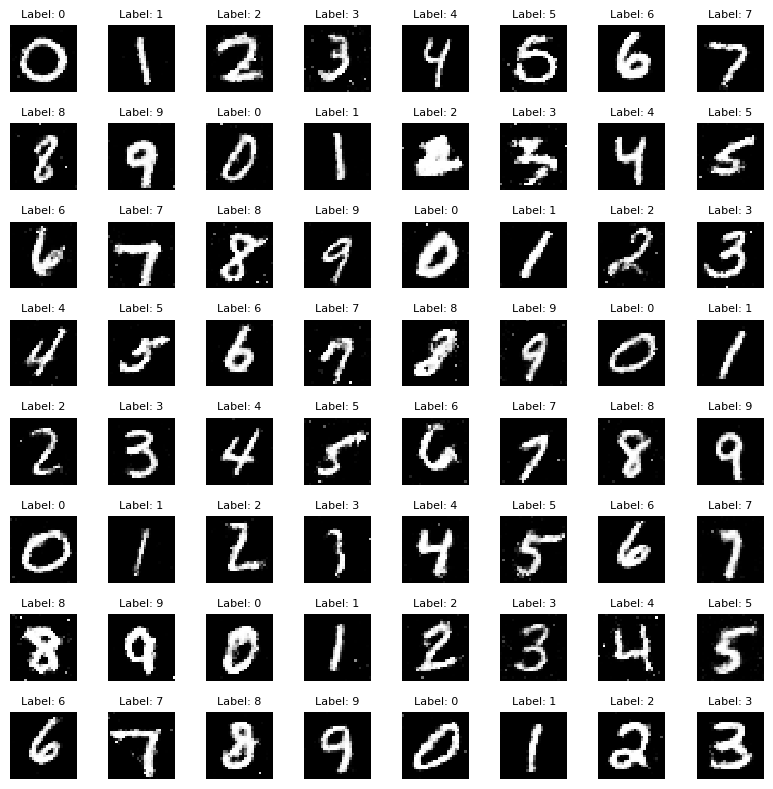

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    sample_noise = torch.randn(64, noise_dim).to(device) # 64 образца случайного шума, каждый из которых имеет размерность noise_dim
    sample_labels = torch.arange(0, 64, device=device) % num_classes
    sample_labels_onehot = F.one_hot(sample_labels, num_classes=num_classes).float().to(device) # С помощью функции F.one_hot получите массив векторов - закодированных меток классов для вашего батча
    fake_samples = conditional_generator(sample_noise, sample_labels_onehot)

    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = fake_samples[i].cpu().view(28, 28).numpy()
        ax.imshow(img, cmap="gray", interpolation="nearest")
        ax.set_title(f"Label: {sample_labels[i].item()}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Примеры генераций, которые должны у вас получиться

## Vanilla VAE

Восстановление

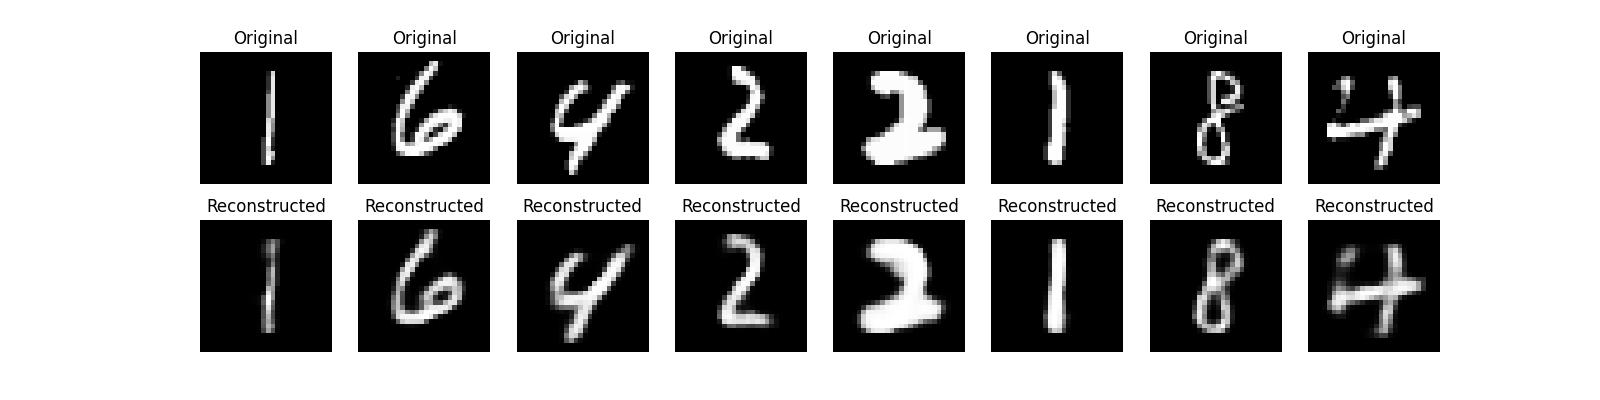

Генерация

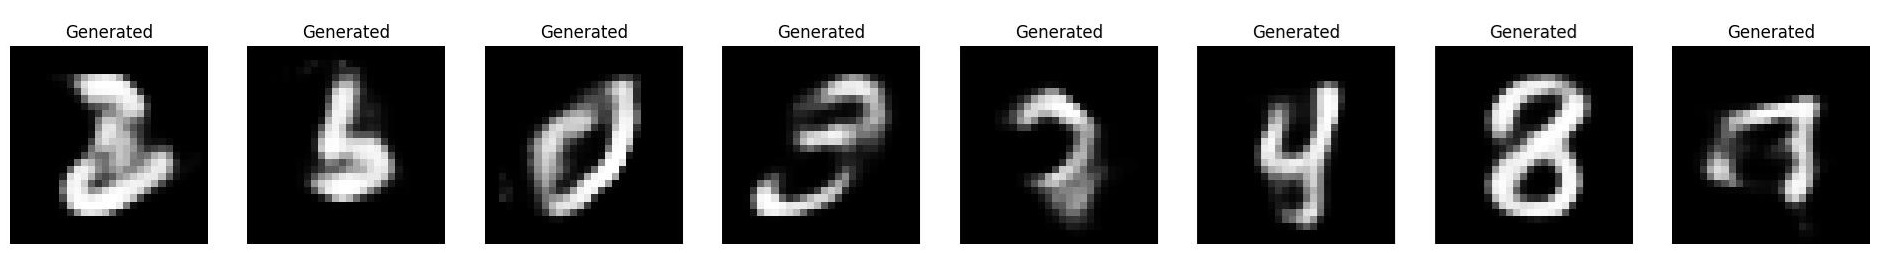

## CVAE

Восстановление

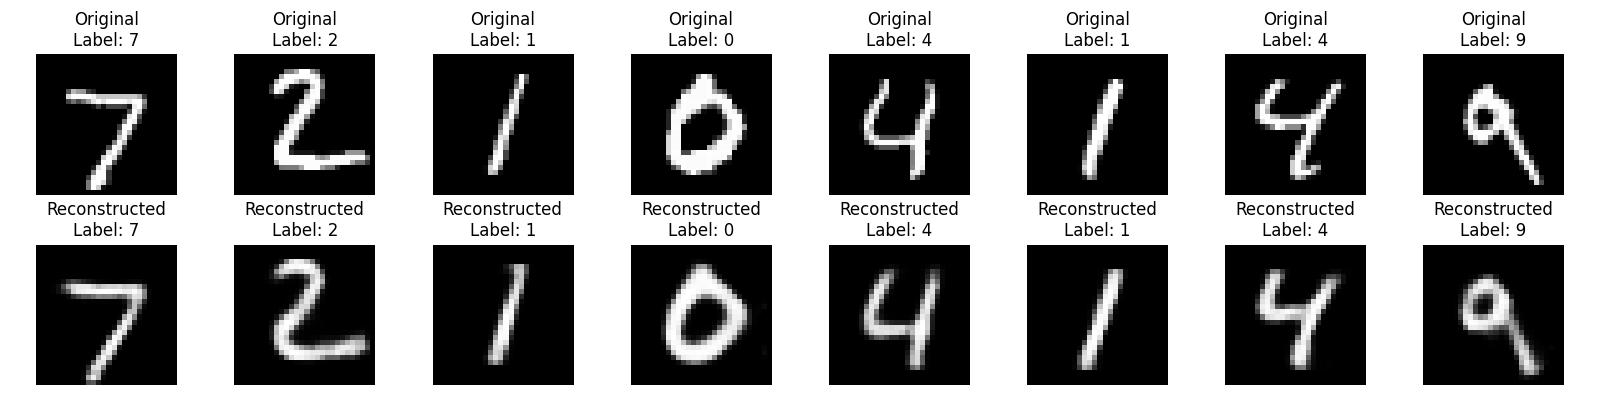

Генерация

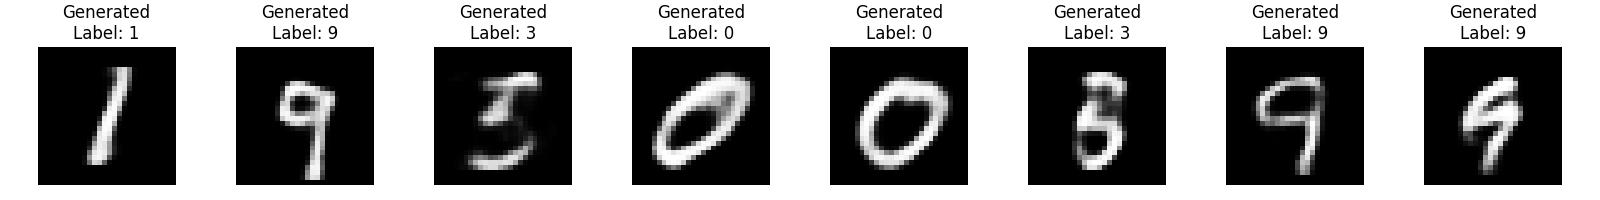

## Улучшенный CVAE

Восстановление

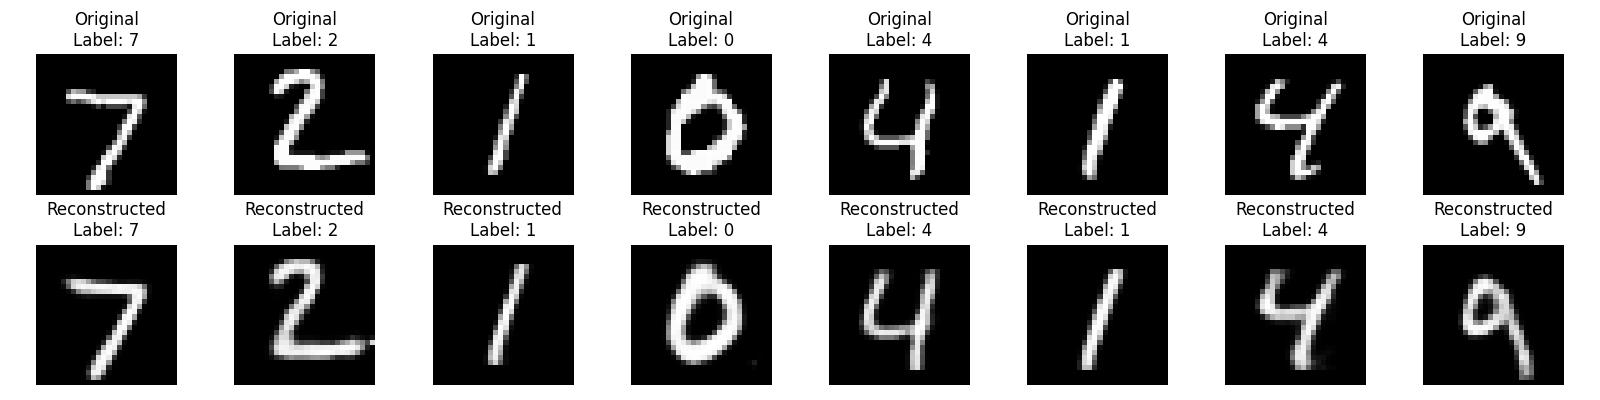

Генерация

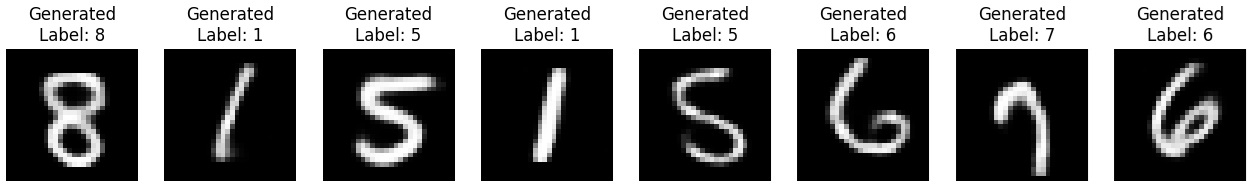

## Vanilla GAN

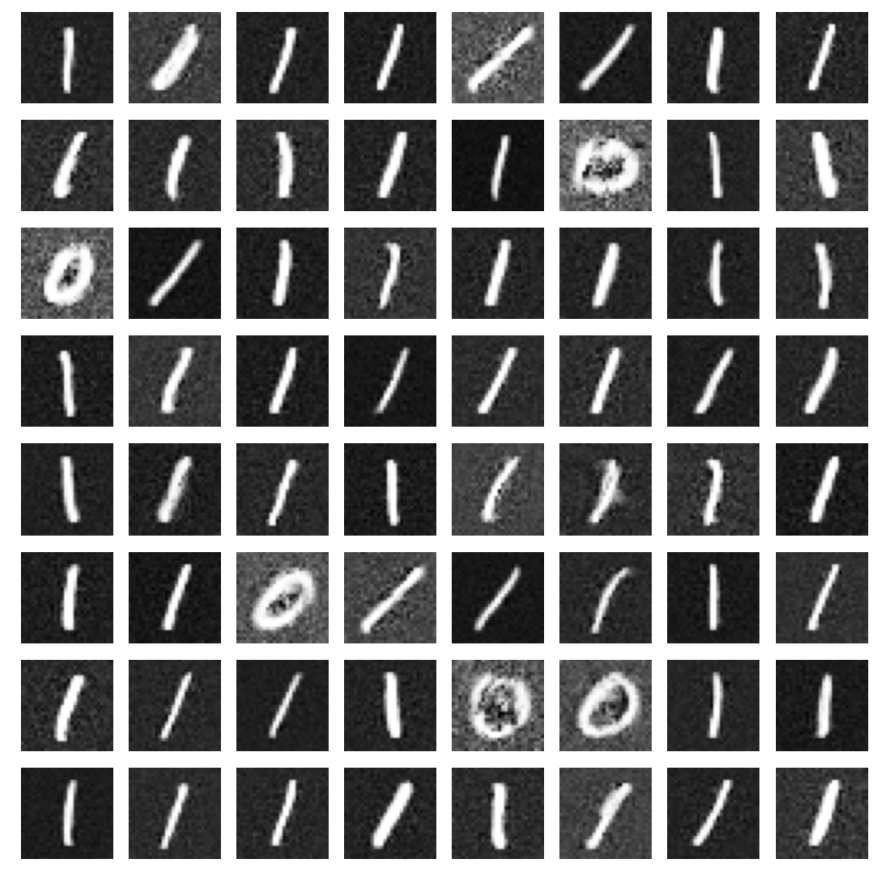

## CGAN

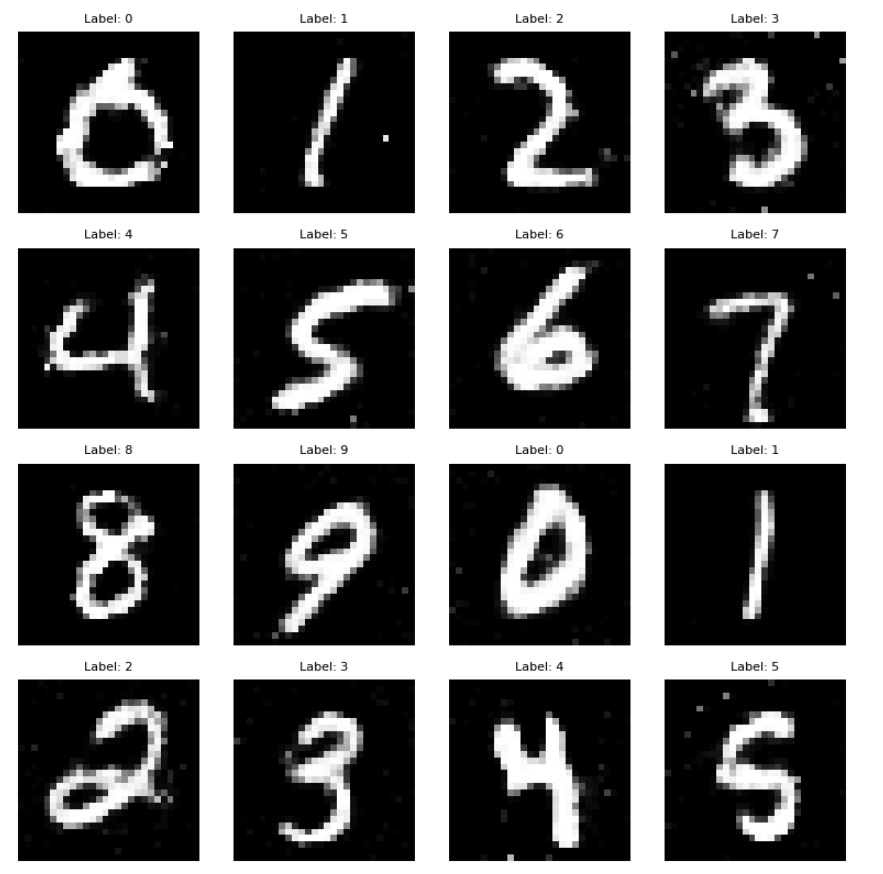

# Задача 3: Задачи со звёздочкой


## Анализ латентного пространства и интерполяция (для VAE и GAN) (1 балл)

Проведите интерполяцию между двумя изображениями: выберите две точки в латентном пространстве и сгенерируйте промежуточные изображения. Задание выполняется на моделях с условной генерацией.

Оцените, насколько плавно и семантически осмысленно происходит переход между различными классами.

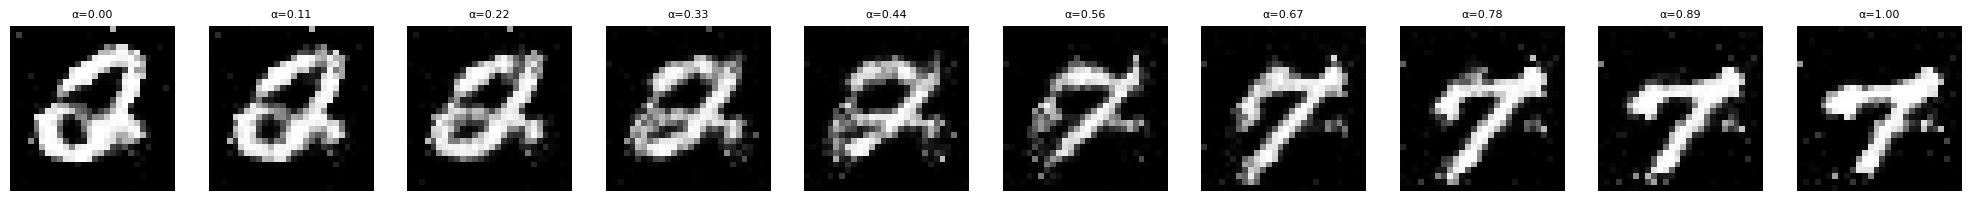

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def interpolate_vectors(v1, v2, steps=10):
    alphas = torch.linspace(0, 1, steps).unsqueeze(1).to(v1.device)
    return (1 - alphas) * v1 + alphas * v2


noise_dim = 100
num_classes = 10

class1 = 2
class2 = 7

c1 = F.one_hot(torch.tensor([class1]), num_classes=num_classes).float().to(device)
c2 = F.one_hot(torch.tensor([class2]), num_classes=num_classes).float().to(device)

z1 = torch.randn(1, noise_dim).to(device)
z2 = torch.randn(1, noise_dim).to(device)

steps = 10
z_interp = interpolate_vectors(z1, z2, steps=steps)
c_interp = interpolate_vectors(c1, c2, steps=steps)

fake_images_interp = conditional_generator(z_interp, c_interp)


fig, axes = plt.subplots(1, steps, figsize=(steps*2, 2))
for i in range(steps):
    img = fake_images_interp[i].view(28, 28).cpu().detach().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'α={i/(steps-1):.2f}', fontsize=8)
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## Примеры результатов визуализации интерполяции

### VAE

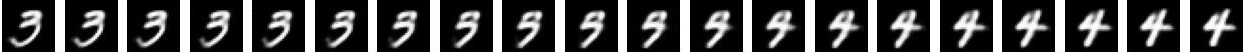

### GAN

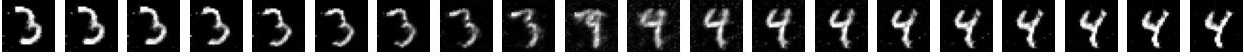

# Контрольные вопросы

### Общие вопросы:

1. Какая модель дает самые четкие изображения? Почему?

2. Рефлексия: Какая архитектура модели показалась вам наиболее интересной? Почему?
  
1. Что такое вариационный автокодировщик (VAE)?  
2. В чем заключается принцип работы генеративно-состязательной сети (GAN)?  
3. Какие основные компоненты входят в архитектуру VAE и GAN?  
4. Для чего используется латентное пространство в VAE?  
5. Что такое репараметризация (reparameterization trick) в VAE и зачем она нужна?  

---

### Вопросы по Variational Autoencoder (VAE):  
8. Какова роль KL-дивергенции в функции потерь VAE?  
7. Какая функция ошибки используется для реконструкции изображений в VAE?  
8. Как в Conditional VAE и Conditional GAN происходит передача метки класса?  

---

### Вопросы по Generative Adversarial Network (GAN):  
11. Какие задачи выполняют генератор и дискриминатор в GAN?
10. Как осуществляется обучение генератора и дискриминатора?  
11. В чем различие между Vanilla GAN и Conditional GAN?  

---

### Вопросы по реализации и обучению моделей:  
14. Как производится загрузка набора данных MNIST в PyTorch?  
18. Почему в обучении моделей используется метод обратного распространения ошибки?

---

# Формат сдачи


Для сдачи работы без очной защиты нужно будет предоставить следующие артефакты:
  1. Ссылка на ноутбук в формте .ipynb в гит-репозитории, где будут представлены реализации моделей и визуализации результатов работы моделей.

Ссылки на все артефакты должны быть загружены в LMS до дедлайна. Кнопка "отправлено" должна быть нажата, черновики не рассматриваются.

При очной сдаче необходимо будет ответить на вопросы из секции "Контрольные вопросы". Вам будут заданы 2-4 (на усмотрение принимающего) случайных вопроса.